# Twitter Sentiment Analysis with Bert
In this notebook we show how to finetune BERT to our annotated dataset coffee tweets data to do sentiment classification. Then we correlated these sentiments (positive, neutral and negative) to coffee prices between 2013 and 2021 .





In [ ]:
## Install the transformers module
!pip install -qq transformers

     |████████████████████████████████| 4.0 MB 4.6 MB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 895 kB 45.5 MB/s 
     |████████████████████████████████| 6.6 MB 31.2 MB/s 


In [ ]:
 
## Import relevant modules
import numpy as np 
import pandas as pd 

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import os

import matplotlib.pyplot as plt

import seaborn as sns

from math import sqrt 
from scipy.stats import norm
from random import choices

from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Set up Drive

In [ ]:
## check is colab is connected to your drive
ls drive/MyDrive/

ls: cannot access 'drive/MyDrive/': No such file or directory


In [ ]:
#drive.flush_and_unmount()


In [ ]:
## Mount colab unto google drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "drive/MyDrive/ANLP/NLP Sentiment Analysis Project/"

/content/drive/.shortcut-targets-by-id/1EEAMp2gMUPTvnKYcU2nsfd_CFpRwX-Fh/NLP Sentiment Analysis Project


# Data:
We use 2 sources of data to train our model. First we use a sentiment140, a prexisting dataset. Then we used our own data set curated from scrapping coffee tweens ans labeling them. 


### Sentiment140 Data
This consists of 1.6 million tweets, half labeled positive and half labeled negative.

## Annotated Data
We selected coffee as a demo food product to use for our annotations analysis.  We annotated 1000 tweets with the keyword ‘coffee’ as positive, neutral or negative.

In our first run of the sentiment classifier model we use the Sentiment140 dataset.  

In [ ]:
t140 = pd.read_csv('sentiment140_data/training.1600000.processed.noemoticon.csv',
                   sep=',',
                   header=None,
                   encoding='latin')

label_text = t140[[0, 5]]

label_text.columns = ['label', 'text']

label_text.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Annotated Data

In our second run of the sentiment classifier we

In [ ]:
###alternative data

t140 = pd.read_csv('coffee_data/coffee_tweets_979.csv',
                   sep=',',
                   header=[0],
                   encoding='latin')

label_text = t140[['tweet','sentiment']]

# Convert labels to range 0-1                                        
#label_text[0] = label_text[0].apply(lambda x: 0 if x == 0 else 1)

# Assign proper column names to labels
label_text.columns = ['text', 'label']

label_text['label'] = label_text['label'] + 1

# Assign proper column names to labels

label_text['label'] = label_text['label'].apply(lambda x: int(x))
label_text.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,text,label
0,$300 for a molded plastic coffee table is some...,1
1,#PUROASTCoffee at #MENOPE \nvia @PUROASTCoffee...,1
2,@tptcourses @Roost_Coffee Following. Thank you...,2
3,Theyâre steadily falling out of the vent and...,1
4,@McDonaldsCanada I'm handing out as many hot m...,2


In [ ]:
label_text['text'][60:90]

60    My morning coffee place is ways takeaway only ...
61    A research assistant once called bad coffee "h...
62    @RoyDaRappah Our fridge is so mf nasty. Itâs...
63    $1.49 any size coffee refills kept me alive al...
64    #NowPlaying: Black Coffee - Buya (Feat. Toshi)...
65    Coffee\n#KQUEST_SUNGHOON #ìíì´í_ì±í ...
66    Need friends to smoke and drink coffee with ð...
67                  @WORXTools For putting coffee on it
68    Winter is well and truly upon us!ð¥¶\n\nEnjoy...
69    @JustEatUK 2 orders placed tonight 1st receive...
70                  Coffee Shop https://t.co/BrCJqxG6ZX
71                  @BenKuchera Coffee has water in it.
72    drinking another cup of coffee at 1 am was not...
73    @currys / @CurrysServices purchased a coffee m...
74    @acksonjackson_ @UplandMe Devils advocate: bos...
75                                        coffee at 3am
76    @KatHaplee Eat more alkaline food, avoid eatin...
77    The dust-covered mug\nAs if saying it does

Then we preprocess the text replacing hashtags and mentions with custom tokens, ensuring that the model won't overfit on them

In [ ]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
  text = hashtags.sub(' hashtag', text)
  text = mentions.sub(' entity', text)
  return text.strip().lower()
  
def match_expr(pattern, string):
  return not pattern.search(string) == None

def get_data_wo_urls(dataset):
    link_with_urls = dataset.text.apply(lambda x: match_expr(urls, x))
    return dataset[[not e for e in link_with_urls]]

In [ ]:
label_text.text = label_text.text.apply(process_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Choose Keyword Here!

In [ ]:
#keyword = 'coffee'

In [ ]:
#label_text[label_text['text'].str.contains(keyword)]

We split the dataset and remove tweets with urls because we do not want them to change the meaning of the text, leading the model to learn wrong patterns. Then we store the datasets, because BERT need to load them from disk

In [ ]:
random.seed(42)

from sklearn.model_selection import train_test_split
TRAIN_SIZE = 0.75
VAL_SIZE = 0.125
dataset_count = len(label_text)

df_train_val, df_test = train_test_split(label_text, test_size=1-TRAIN_SIZE-VAL_SIZE, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=VAL_SIZE / (VAL_SIZE + TRAIN_SIZE), random_state=42)

print("TRAIN size:", len(df_train))
print("VAL size:", len(df_val))
print("TEST size:", len(df_test))

TRAIN size: 733
VAL size: 123
TEST size: 123


In [ ]:
#df_train = get_data_wo_urls(df_train)
df_train.head()

,text,label
36,"entity entity entity entity entity entity yup,...",1
621,i could let recent events be the catalyst for ...,2
356,.@sophia_iv from google will be joining us for...,1
694,"so there's a ""popular movement"" amongst the su...",1
688,entity entity wish i could like this 100 times...,2


In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
df_train = df_train[:20000]
df_val = df_val[:4000]
df_test = df_test[:4000]

In [ ]:
df_train.sample(frac=1.0).reset_index(drop=True).to_csv('sentiment140_data/train.tsv', sep='\t', index=None, header=None)
df_val.to_csv('sentiment140_data/dev.tsv', sep='\t', index=None, header=None)
df_test.to_csv('sentiment140_data/test.tsv', sep='\t', index=None, header=None)
#! cd dataset && ls

## Data Prep for BERT


In [ ]:
#https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/



In [ ]:
### Demo on how BERT tokenization works
#tokenize the inputs to work with the BERT classifier

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
sample_txt = df_train.loc[0]['text']

sample_txt

'entity entity entity entity entity entity yup, entity is my busâ\x80¦ https://t.co/rs2uzt6mug'

In [ ]:
## encoding sample text using Bert encoder
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
## Tokenize sample text using Bert encoder
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: entity entity entity entity entity entity yup, entity is my busâ¦ https://t.co/rs2uzt6mug
   Tokens: ['entity', 'entity', 'entity', 'entity', 'entity', 'entity', 'yu', '##p', ',', 'entity', 'is', 'my', 'bus', '##a', '##¦', 'https', ':', '/', '/', 't', '.', 'co', '/', 'rs', '##2', '##uz', '##t', '##6', '##mu', '##g']
Token IDs: [9178, 9178, 9178, 9178, 9178, 9178, 9805, 2361, 1010, 9178, 2003, 2026, 3902, 2050, 29649, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 12667, 2475, 17040, 2102, 2575, 12274, 2290]


In [1]:
# encoding = tokenizer.encode_plus(
#   sample_txt,
#   max_length=32,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=False,
#   pad_to_max_length=True,
#   return_attention_mask=True,
#   return_tensors='pt',  # Return PyTorch tensors
# )

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'entity',
 'entity',
 'entity',
 'entity',
 'entity',
 'entity',
 'yu',
 '##p',
 ',',
 'entity',
 'is',
 'my',
 'bus',
 '##a',
 '##¦',
 'https',
 ':',
 '/',
 '/',
 't',
 '.',
 'co',
 '/',
 'rs',
 '##2',
 '##uz',
 '##t',
 '##6',
 '##mu',
 '##g',
 '[SEP]']

In [ ]:
## tokenize training data using BERT
token_lens = []
for txt in df_train['text'][:10000]:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


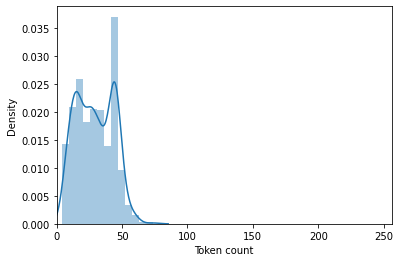

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 32

In [ ]:
### Create a PyTorch dataset object

class GPTweetDataset(Dataset):
  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.tweets)
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
## Create Data Loader
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPTweetDataset(
    tweets=df['text'].to_numpy(),
    targets=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BATCH_SIZE = 16


In [ ]:
## split data into train, test and validation set
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
## print shape of one input of batch size 16
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 32])
torch.Size([16, 32])
torch.Size([16])


## Training The BERT Model with PyTorch

In [ ]:
EPOCHS = 50

In [ ]:
## load pretrained Bert Model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
encoding

{'input_ids': tensor([[  101,  9178,  9178,  9178,  9178,  9178,  9178,  9805,  2361,  1010,
          9178,  2003,  2026,  3902,  2050, 29649, 16770,  1024,  1013,  1013,
          1056,  1012,  2522,  1013, 12667,  2475, 17040,  2102,  2575, 12274,
          2290,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
## add encoder to last layer of BERT model
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
b = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

pooler_output = b['pooler_output']

In [ ]:
#pooler_output

In [ ]:
## sentiment classifer class
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    #_, pooled_output = self.bert(
    #  input_ids=input_ids,
    #  attention_mask=attention_mask
    #)
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
      )['pooler_output']
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(3) #2 classes, may need to change to three if we do good/neutral/bad


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
model = model.to(device)

In [ ]:
#model.load_state_dict(torch.load('best_model_state.bin'))


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
torch.Size([16, 160])
torch.Size([16, 160])

torch.Size([16, 32])
torch.Size([16, 32])


torch.Size([16, 160])

In [ ]:
import torch.nn.functional as F

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)


tensor([[0.2372, 0.3732, 0.3895],
        [0.3120, 0.4278, 0.2601],
        [0.3877, 0.2525, 0.3598],
        [0.4013, 0.3219, 0.2767],
        [0.2914, 0.2749, 0.4337],
        [0.2505, 0.4159, 0.3336],
        [0.4184, 0.2140, 0.3676],
        [0.1786, 0.3692, 0.4522],
        [0.3081, 0.2541, 0.4378],
        [0.2685, 0.3425, 0.3890],
        [0.2216, 0.4655, 0.3129],
        [0.3467, 0.3184, 0.3350],
        [0.4227, 0.2842, 0.2931],
        [0.4759, 0.3082, 0.2159],
        [0.2638, 0.5099, 0.2264],
        [0.2973, 0.3101, 0.3926]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.8596806124500607 accuracy 0.5798090040927695


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.725976012647152 accuracy 0.6504065040650407

Epoch 2/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.6118490893555724 accuracy 0.7271487039563438


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6591797694563866 accuracy 0.6991869918699187

Epoch 3/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.3569702467192774 accuracy 0.8540245566166439


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7619744576513767 accuracy 0.7235772357723578

Epoch 4/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.1721834441869641 accuracy 0.9481582537517054


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.0424025282263756 accuracy 0.7235772357723578

Epoch 5/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.06181070455552443 accuracy 0.9822646657571623


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.2857520952820778 accuracy 0.7317073170731708

Epoch 6/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.02179548079046704 accuracy 0.9959072305593452


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.347278654575348 accuracy 0.7398373983739838

Epoch 7/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.013853652615343099 accuracy 0.9972714870395635


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.510294295847416 accuracy 0.7154471544715448

Epoch 8/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.008007555873558411 accuracy 0.9986357435197817


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.4678133353590965 accuracy 0.7154471544715448

Epoch 9/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.002369370331744785 accuracy 0.9986357435197817


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.5515112280845642 accuracy 0.7235772357723578

Epoch 10/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.002704286904823359 accuracy 0.9986357435197817


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.5570855513215065 accuracy 0.7235772357723578

CPU times: user 1min 31s, sys: 25.6 s, total: 1min 57s
Wall time: 2min 15s


In [ ]:
[x.item() for x in history['val_acc']]

[0.6504065040650407,
 0.6991869918699187,
 0.7235772357723578,
 0.7235772357723578,
 0.7317073170731708,
 0.7398373983739838,
 0.7154471544715448,
 0.7154471544715448,
 0.7235772357723578,
 0.7235772357723578]

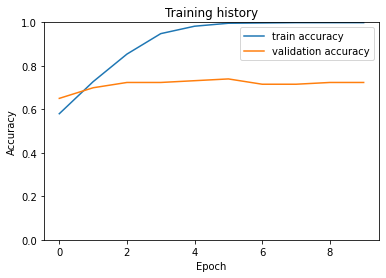

In [ ]:
plt.plot([x.item() for x in history['train_acc']], label='train accuracy')
plt.plot([x.item() for x in history['val_acc']], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluate Model

In [ ]:
model.load_state_dict(torch.load('best_model_state.bin'))


<All keys matched successfully>

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.7317073170731708

In [ ]:
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

NameError: ignored

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.50      0.42      0.45        12
           1       0.80      0.81      0.81        69
           2       0.67      0.69      0.68        42

    accuracy                           0.73       123
   macro avg       0.66      0.64      0.65       123
weighted avg       0.73      0.73      0.73       123



In [ ]:
label_text['label'].value_counts()

1    558
2    326
0     95
Name: label, dtype: int64

In [ ]:
558/(558+326+95)

0.5699693564862104

https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

## Bootstrap Confidence Intervals

In [ ]:
def accuracy(truth, predictions):
    correct=0.
    for idx in range(len(truth)):
        g=truth[idx]
        p=predictions[idx]
        if g == p:
            correct+=1
    return correct/len(truth)

In [ ]:
def F1(truth, predictions):
    correct=0.
    trials=0.
    trues=0.
    for idx in range(len(truth)):
        g=truth[idx]
        p=predictions[idx]
        if g == p and g == 1:
            correct+=1
        if g == 1:
            trues+=1
        if p == 1:
            trials+=1
            
    precision=correct/trials if trials > 0 else 0
    recall=correct/trues if trues > 0 else 0
    f=(2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0
    return f

In [ ]:
def bootstrap(gold, predictions, metric, B=10000, confidence_level=0.95):
    critical_value=(1-confidence_level)/2
    lower_sig=100*critical_value
    upper_sig=100*(1-critical_value)
    data=[]
    for g, p in zip(gold, predictions):
        data.append([g,p])

    accuracies=[]
    
    for b in range(B):
        choice=choices(data, k=len(data))
        choice=np.array(choice)
        accuracy=metric(choice[:,0], choice[:,1])
        
        accuracies.append(accuracy)
    
    percentiles=np.percentile(accuracies, [lower_sig, 50, upper_sig])
    
    lower=percentiles[0]
    median=percentiles[1]
    upper=percentiles[2]
    
    return lower, median, upper


In [ ]:
lower, median, upper = bootstrap(y_test, y_pred, accuracy)

In [ ]:
print('Accuracy confidence intervals.  Lower: ' + str(lower) + ', Middle: ' + str(median) + ', Upper: ' + str(upper))

Accuracy confidence intervals.  Lower: 0.6504065040650406, Middle: 0.7317073170731707, Upper: 0.8048780487804879


In [ ]:
f1_lower, f1_median, f1_upper = bootstrap(y_test, y_pred, F1)

In [ ]:
print('F1 confidence intervals.  Lower: ' + str(f1_lower) + ', Middle: ' + str(f1_median) + ', Upper: ' + str(f1_upper))

F1 confidence intervals.  Lower: 0.7285714285714286, Middle: 0.8059701492537314, Upper: 0.8714285714285713


## Predict on Other Tweets

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {prediction}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : tensor([1], device='cuda:0')


In [ ]:
def get_prediction(tweet):
  
  #step from the very top of the notebook
  tweet = process_text(tweet)

  encoded_tweet = tokenizer.encode_plus(
    tweet,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = encoded_tweet['input_ids'].to(device)
  attention_mask = encoded_tweet['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  return(prediction[0].item())

## Misclassifications

In [ ]:
df_test['predictions'] = df_test['text'].apply(lambda x: get_prediction(x))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
df_test_negative = df_test[df_test['label'] == 1]

df_test_negative = df_test_negative.reset_index(drop=True)

for i in range(0, len(df_test_negative)):
  print(df_test_negative['text'][i] + '    Label: ' + str(df_test_negative['label'][i]) +
        '    Prediction: ' + str(df_test_negative['predictions'][i]))

we have stop in la fonda hotel for coffee, itâs a beautiful hotel inside and out ðð we  recommend  it  ð https://t.co/oegyjlifxy    Label: 1    Prediction: 1
entity the coffee part sounds nuts.    Label: 1    Prediction: 1
wanting your kiss, coffee-scented, it's too far away; too hazy.    Label: 1    Prediction: 1
entity i'm still on coffee. 
water bottle and cardio soon though... with some proper outdoor clothes, i guess.
dâ¦ https://t.co/1lsqhdjiqn    Label: 1    Prediction: 1
get your caffeine fix with these trainers made from coffee grounds | euronews https://t.co/lzeegfi8ol    Label: 1    Prediction: 1
this whole mv / mana rock debate is why i think mirrored lotus should be printed instead of being a playtest card.â¦ https://t.co/sm6ym6pgip    Label: 1    Prediction: 1
to register for this online event, visit https://t.co/kw89xzlioa    Label: 1    Prediction: 1
entity for putting coffee on it    Label: 1    Prediction: 1
new tipping rule for coffee shops: if you ask m

## Predicting Sentiment on Tweets from the Twitter API

In [ ]:
df = pd.read_csv('food_tweets.csv')

In [ ]:
df['predictions'] = df['tweet'].apply(lambda x: get_prediction(x))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
df

,Unnamed: 0,tweet,word,predictions
0,0,@DefGrady @vladktoruuro Grady trying to cospla...,apple,0
1,1,@FarrellAllan1 Candy Apple Red,apple,1
2,2,@FlockLeader_ Not the beefaroni grand champion...,apple,0
3,3,this my favorite song rn. https://t.co/PV3gkEr2gV,apple,1
4,4,My brain score is 1733. Download MindPal and t...,apple,1
...,...,...,...,...
1995,195,i needa learn how to cook fr tho bc how tf i’m...,steak,0
1996,196,"Reverse seared tomahawk steak, roasted in my k...",steak,1
1997,197,@TheDragonOTC Ya that’s crazy talk! 😜 but I d...,steak,1
1998,198,I do wanna grill a steak before it get cold cold,steak,0


In [ ]:
df.groupby('word').sum()['predictions']

word
apple        134
banana       134
bread        127
broccoli     133
coffee       130
donut        134
ice cream    134
olives       147
pasta        140
steak        138
Name: predictions, dtype: int64

In [ ]:
df.to_csv('food_tweets_diverse.csv')

## Graphs

In [ ]:
df1 = pd.read_csv('food_tweets_agriculture.csv')

In [ ]:
df1['predictions'] = df1['tweet'].apply(lambda x: get_prediction(x))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
df1_grouped = df1.groupby('word').sum()['predictions']

In [ ]:
df1_grouped = df1_grouped.sort_values()

In [ ]:
df1_grouped = (df1_grouped/200) * 100

In [ ]:
df2 = pd.read_csv('food_tweets_diverse.csv')

In [ ]:
df2['predictions'] = df2['tweet'].apply(lambda x: get_prediction(x))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
df2_grouped = df2.groupby('word').sum()['predictions']

In [ ]:
df2_grouped = df2_grouped.sort_values()

In [ ]:
df2_grouped = (df2_grouped/200) * 100

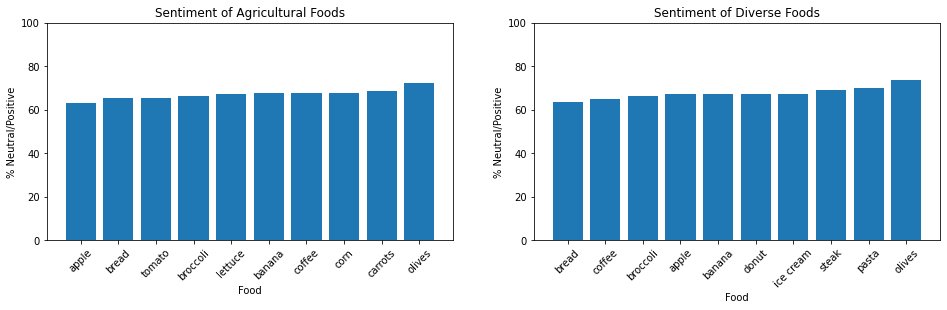

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.set_xticklabels(df1_grouped.index, rotation=45)
ax2.set_xticklabels(df2_grouped.index, rotation=45)


ax1.bar(df1_grouped.index, df1_grouped)
ax2.bar(df2_grouped.index, df2_grouped)

ax1.set_title('Sentiment of Agricultural Foods')
ax2.set_title('Sentiment of Diverse Foods')

ax1.set_xlabel('Food')
ax2.set_xlabel('Food')

ax1.set_ylabel('% Neutral/Positive')
ax2.set_ylabel('% Neutral/Positive')


ax1.set_ylim([0, 100])
ax2.set_ylim([0, 100])


plt.show()

## Classify the snscrape tweets

In [ ]:
df = pd.read_json('coffee_post_pandemic_tweets.json', lines=True)

In [ ]:
df = df[~df['content'].str.contains('@')].reset_index(drop=True)

In [ ]:
df = df[['date','content']]

In [ ]:
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
df = df.sort_values('date')

In [ ]:
#df['predictions'] = df['content'].apply(lambda x: get_prediction(x))

In [ ]:
#df.to_csv('coffee_post_pandemic_tweets_preds.csv', index=False)

In [ ]:
df = pd.read_csv('coffee_post_pandemic_tweets_preds.csv')

In [ ]:
df_positive_timeseries = df[df['predictions'] == 2].groupby('date').count()['predictions'] / df.groupby('date').count()['predictions']
df_neutral_timeseries = df[df['predictions'] == 1].groupby('date').count()['predictions'] / df.groupby('date').count()['predictions']
df_negative_timeseries = df[df['predictions'] == 0].groupby('date').count()['predictions'] / df.groupby('date').count()['predictions']




In [ ]:
df_positive_timeseries = df_positive_timeseries.dropna()
df_neutral_timeseries = df_neutral_timeseries.dropna()
df_negative_timeseries = df_negative_timeseries.dropna()


In [ ]:
#https://www.macrotrends.net/2535/coffee-prices-historical-chart-data

coffee_prices = pd.read_csv('coffee_prices.csv')

In [ ]:
coffee_prices.columns = ['date','price']

In [ ]:
from datetime import datetime


In [ ]:
coffee_prices['date'] = coffee_prices['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').strftime('%Y-%m-%d'))

In [ ]:
coffee_prices_matched = coffee_prices[coffee_prices['date'].isin(list(df_positive_timeseries.index))]

In [ ]:
coffee_prices = coffee_prices.reset_index(drop=True)

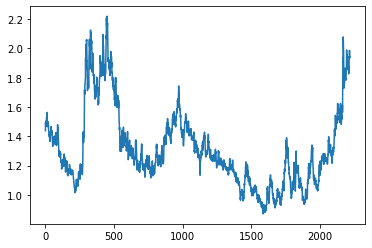

In [ ]:
plt.plot(coffee_prices['price'])

In [ ]:
matched_indices = [int(np.round(x)) for x in np.linspace(0, len(coffee_prices)-1, num=36)]

In [ ]:
len(matched_indices)

36

In [ ]:
coffee_prices_matched = coffee_prices.iloc[matched_indices].reset_index(drop=True)

In [ ]:
len(coffee_prices_matched)

36

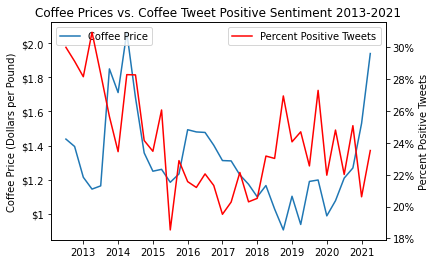

In [ ]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Positive Sentiment 2013-2021')

ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
ax1.set_ylabel('Coffee Price (Dollars per Pound)')
ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

ax2 = ax1.twinx()
ax2.plot(df_positive_timeseries, color='red', label='Percent Positive Tweets')
ax2.set_ylabel('Percent Positive Tweets')
ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#plt.legend()

plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

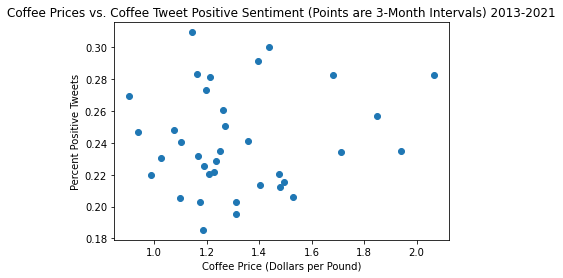

In [ ]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Positive Sentiment (Points are 3-Month Intervals) 2013-2021')

#ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
#ax1.set_ylabel('Coffee Price (Dollars per Pound)')
#ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

#ax2 = ax1.twinx()
#ax2.plot(df_positive_timeseries, color='red', label='Percent Positive Tweets')
#ax2.set_ylabel('Percent Positive Tweets')
#ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])

plt.scatter(coffee_prices_matched['price'], df_positive_timeseries)

plt.xlabel('Coffee Price (Dollars per Pound)')
plt.ylabel('Percent Positive Tweets')

#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

#plt.legend()

#plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

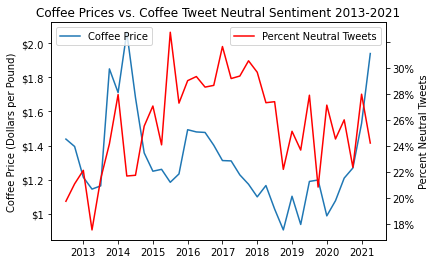

In [ ]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Neutral Sentiment 2013-2021')

ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
ax1.set_ylabel('Coffee Price (Dollars per Pound)')
ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

ax2 = ax1.twinx()
ax2.plot(df_neutral_timeseries, color='red', label='Percent Neutral Tweets')
ax2.set_ylabel('Percent Neutral Tweets')
ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#plt.legend()

plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

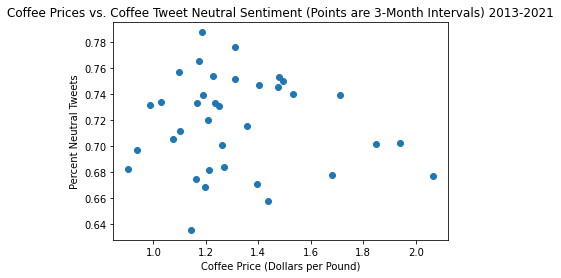

In [ ]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Neutral Sentiment (Points are 3-Month Intervals) 2013-2021')

#ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
#ax1.set_ylabel('Coffee Price (Dollars per Pound)')
#ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

#ax2 = ax1.twinx()
#ax2.plot(df_positive_timeseries, color='red', label='Percent Positive Tweets')
#ax2.set_ylabel('Percent Positive Tweets')
#ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])

plt.scatter(coffee_prices_matched['price'], df_neutral_timeseries)

plt.xlabel('Coffee Price (Dollars per Pound)')
plt.ylabel('Percent Neutral Tweets')

#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

#plt.legend()

#plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

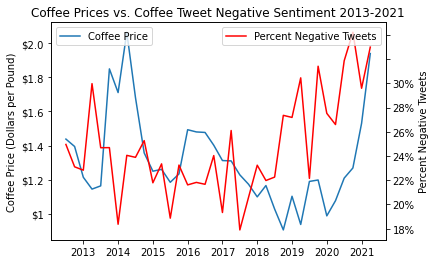

In [ ]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Negative Sentiment 2013-2021')

ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
ax1.set_ylabel('Coffee Price (Dollars per Pound)')
ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

ax2 = ax1.twinx()
ax2.plot(df_negative_timeseries, color='red', label='Percent Negative Tweets')
ax2.set_ylabel('Percent Negative Tweets')
ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#plt.legend()

plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

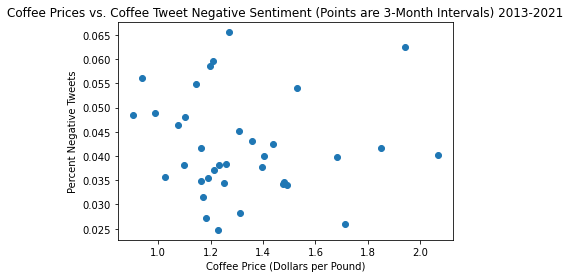

In [ ]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Negative Sentiment (Points are 3-Month Intervals) 2013-2021')

#ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
#ax1.set_ylabel('Coffee Price (Dollars per Pound)')
#ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

#ax2 = ax1.twinx()
#ax2.plot(df_positive_timeseries, color='red', label='Percent Positive Tweets')
#ax2.set_ylabel('Percent Positive Tweets')
#ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])

plt.scatter(coffee_prices_matched['price'], df_negative_timeseries)

plt.xlabel('Coffee Price (Dollars per Pound)')
plt.ylabel('Percent Negative Tweets')

#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

#plt.legend()

#plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

In [ ]:
from scipy import stats

#https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html

# Y and Z are numpy arrays or lists of variables 
print(stats.pearsonr(coffee_prices_matched['price'], df_positive_timeseries))
print(stats.pearsonr(coffee_prices_matched['price'], df_neutral_timeseries))
print(stats.pearsonr(coffee_prices_matched['price'], df_negative_timeseries))

(0.11353160900205256, 0.509712087759363)
(-0.08115851860112518, 0.6379669132674803)
(-0.06408105495641175, 0.7104147343397662)
